<a href="https://colab.research.google.com/github/feteiha/ML-Course/blob/master/Movie_Recommendations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Movie Recommendations

Recommendations are a common machine learning task widely used by many leading companies, such as Netflix, Amazon, and YouTube. If you have used any of these online services, you are familiar with recommendations that are often prefixed with "You might also like.." or "Recommended items other customers buy...".

There are many ways to generate recommendations. It could be done based on simple criteria, such as movie genre, e.g. comedies or action adventure. More sophisticated recommendations might consider many more factors, such as the director, when the movie was produced and so on.

In this example, we will use a common, straightforward method known as [collaborative filtering](https://en.wikipedia.org/wiki/Collaborative_filtering). This method is based on idea that many customers have similar likes and dislikes. It also considers similarities between products. It's a simple, yet effective technique that depends only user preferences, such as product ratings. If you have a sufficiently large dataset of ratings from your customers, then this approach is a good place to start.

In [1]:
%tensorflow_version 2.x

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Dense, Add, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder

# Load data

In this example, we will make movie recommendations given about 100,000 samples from roughly 10,000 customers or users.

The data set is freely available on the [MovieLens website](https://grouplens.org/datasets/movielens/).

In [3]:
!wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip

--2020-07-05 22:02:21--  http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K  1.47MB/s    in 0.6s    

2020-07-05 22:02:22 (1.47 MB/s) - ‘ml-latest-small.zip’ saved [978202/978202]



In [4]:
!unzip ml-latest-small.zip

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


In [5]:
movies = pd.read_csv('ml-latest-small/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
ratings = pd.read_csv('ml-latest-small/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [7]:
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [21]:
ratings.userId.unique

<bound method Series.unique of 0           1
1           5
2           7
3          15
4          17
         ... 
100831    610
100832    610
100833    610
100834    610
100835    610
Name: userId, Length: 100836, dtype: int64>

In [20]:
movies.movieId.unique

<bound method Series.unique of 0            1
1            2
2            3
3            4
4            5
         ...  
9737    193581
9738    193583
9739    193585
9740    193587
9741    193609
Name: movieId, Length: 9742, dtype: int64>

## Join Ratings with Movies

The ratings don't contain movie titles, so let's join or merge these two sets for convenience.

In [17]:
ratings = ratings.merge(movies, on='movieId').drop(['genres','timestamp'],axis=1)
ratings.head()

,userId,movieId,rating,title
0,1,1,4.0,Toy Story (1995)
1,5,1,4.0,Toy Story (1995)
2,7,1,4.5,Toy Story (1995)
3,15,1,2.5,Toy Story (1995)
4,17,1,4.5,Toy Story (1995)


## Generate Sequential Identifiers

`userId` and `movieId` are not sequential, which causes problems for our model. To compensate, we can use the [LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) class from [scikit-learn](https://scikit-learn.org/) to generate sequential identifiers for users and movies. The original identifiers are still available, so we can always join back to the original data set if needed.

In [18]:
user_enc = LabelEncoder()
ratings['userSeq'] = user_enc.fit_transform(ratings['userId'].values)

item_enc = LabelEncoder()
ratings['movieSeq'] = item_enc.fit_transform(ratings['movieId'].values)

ratings.head()

,userId,movieId,rating,title,userSeq,movieSeq
0,1,1,4.0,Toy Story (1995),0,0
1,5,1,4.0,Toy Story (1995),4,0
2,7,1,4.5,Toy Story (1995),6,0
3,15,1,2.5,Toy Story (1995),14,0
4,17,1,4.5,Toy Story (1995),16,0


## Train/Test Split

This case is a bit unusual because we need ratings for every movie from every user to train an accurate model. If we used a traditional split, some movies might be left out, which will cause problems during prediction.

For this reason, we will use all of the data for training and a subset for model validation only.

In [19]:
train_unused, test = train_test_split(ratings, test_size=0.20, random_state=0)

# All data is used for training
train = ratings

numUsers = len(train.userSeq.unique())
numMovies = len(train.movieSeq.unique())
print((numUsers, numMovies))
print((len(train), len(test)))

(610, 9724)
(100836, 20168)


## Recommendation Model

Collaborative filtering tries to minimize the error between a predicted value and ground truth. This is similar to many supervised machine learning problems. The model learns a set of features that similar movies share. The number of features could be as simple as the genre or more complex. The `numFeatures` variable below is a hyperparameter that can be tuned to optimize performance.

This model uses the [Keras functional API](https://keras.io/getting-started/functional-api-guide/) rather than adding layers to a Sequential model. This is necessary because we have two sets of inputs, userSeq and movieSeq.

In [36]:
numFeatures = 60
dropout = 0.0

user_input = Input(shape=(1,))
user_emb = Embedding(numUsers, numFeatures)(user_input)
flat_user = Flatten()(user_emb)
user_dropout = Dropout(dropout)(flat_user)

movie_input = Input(shape=(1,))
movie_emb = Embedding(numMovies, numFeatures)(movie_input)
flat_movie = Flatten()(movie_emb)
movie_dropout = Dropout(dropout)(flat_movie)

dotProduct = Dot(axes=1)([user_dropout, movie_dropout])

user_bias = Embedding(numUsers, 1)(user_input)
movie_bias = Embedding(numMovies, 1)(movie_input)
sum = Add()([dotProduct, user_bias, movie_bias])
flat_sum = Flatten()(sum)
output = Dropout(dropout)(flat_sum)

model = Model([user_input, movie_input], output)

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, 1, 60)        36600       input_7[0][0]                    
__________________________________________________________________________________________________
embedding_13 (Embedding)        (None, 1, 60)        583440      input_8[0][0]                    
____________________________________________________________________________________________

## Model Training

Epoch 1/10
3152/3152 [==============================] - 22s 7ms/step - loss: 6.0592 - val_loss: 1.3667
Epoch 2/10
3152/3152 [==============================] - 21s 7ms/step - loss: 1.1128 - val_loss: 0.7810
Epoch 3/10
3152/3152 [==============================] - 21s 7ms/step - loss: 0.7976 - val_loss: 0.6207
Epoch 4/10
3152/3152 [==============================] - 21s 7ms/step - loss: 0.6492 - val_loss: 0.5101
Epoch 5/10
3152/3152 [==============================] - 21s 7ms/step - loss: 0.5305 - val_loss: 0.4161
Epoch 6/10
3152/3152 [==============================] - 21s 7ms/step - loss: 0.4318 - val_loss: 0.3258
Epoch 7/10
3152/3152 [==============================] - 20s 6ms/step - loss: 0.3462 - val_loss: 0.2605
Epoch 8/10
3152/3152 [==============================] - 21s 7ms/step - loss: 0.2762 - val_loss: 0.2018
Epoch 9/10
3152/3152 [==============================] - 21s 7ms/step - loss: 0.2184 - val_loss: 0.1584
Epoch 10/10
3152/3152 [==============================] - 21s 7ms/step - l

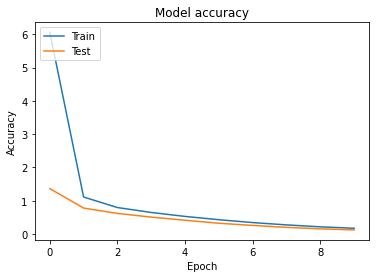

In [37]:
model.compile(loss='mean_squared_error', optimizer=Adam())
history = model.fit([train.userSeq, train.movieSeq], train.rating,
                    batch_size=32, epochs=10, verbose=1,
                    validation_data=([test.userSeq, test.movieSeq], test.rating))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Notice the validation loss is slightly lower than the training loss. If the model was overfitting, then the opposite would be true, so this is a peculiar case.

There are a few reasons this can happen:


1.   Keras artifact explained the [Keras FAQ](https://keras.io/getting-started/faq/#why-is-the-training-loss-much-higher-than-the-testing-loss). Keras computes training loss as the average during training time, which can change quite a bit during one epoch. Validation is computed at the end of an epoch when the model loss is probably lower.
2.   The test set is not not representative of the training set. In some cases, the test set might be easier to predict than the training set. This could happen if a very small test set is used.






## Make Predictions

We can make predictions for a given user by creating a numpy array of all movies and a numpy array of the same dimension filled with just the one user we are interested in. The model will predict ratings for the specified user given all movies in the full data set.

We can then sort the data set by predicted rating descending to get the best recommendations first.

In [29]:
# The user for whom we want to make recommendations
userNumber = 2

uniqueMovies = ratings.drop_duplicates(subset=['movieSeq'])

movie_vector = uniqueMovies.movieSeq.values
user_vector = np.ones((len(uniqueMovies),)) * userNumber
predictions = model.predict([user_vector, movie_vector])
predictedDF = uniqueMovies.copy()
predictedDF['Predictions'] = predictions

predictedDF.sort_values(by='Predictions', ascending=False).head(5)

,userId,movieId,rating,title,userSeq,movieSeq,Predictions
18812,3,5746,5.0,Galaxy of Terror (Quest) (1981),2,4039,5.590826
18810,3,5181,5.0,Hangar 18 (1980),2,3729,5.497607
18800,3,4518,5.0,The Lair of the White Worm (1988),2,3330,5.359670
18830,3,26409,4.5,"Clonus Horror, The (1979)",2,5491,5.039768
18651,3,2851,5.0,Saturn 3 (1980),2,2140,5.029535


## Error Analysis

Let's look at some movies where the ground truth did not compare well with predictions.

In [30]:
oneUser = predictedDF[predictedDF.userSeq == userNumber].copy()
oneUser['Error'] = (oneUser.rating - oneUser.Predictions)**2
oneUser.sort_values(by='Error', ascending=False).head(5)

,userId,movieId,rating,title,userSeq,movieSeq,Predictions,Error
18812,3,5746,5.0,Galaxy of Terror (Quest) (1981),2,4039,5.590826,0.349075
18195,3,849,5.0,Escape from L.A. (1996),2,656,4.411321,0.346543
18830,3,26409,4.5,"Clonus Horror, The (1979)",2,5491,5.039768,0.291349
18826,3,7899,4.5,Master of the Flying Guillotine (Du bi quan wa...,2,5042,5.028554,0.279369
18810,3,5181,5.0,Hangar 18 (1980),2,3729,5.497607,0.247612


In [32]:
ratings[ratings.movieSeq == 656].sort_values(by='rating', ascending=True)

,userId,movieId,rating,title,userSeq,movieSeq
18215,297,849,1.0,Escape from L.A. (1996),296,656
18209,149,849,1.0,Escape from L.A. (1996),148,656
18235,606,849,1.5,Escape from L.A. (1996),605,656
18211,182,849,1.5,Escape from L.A. (1996),181,656
18233,599,849,1.5,Escape from L.A. (1996),598,656
18231,576,849,1.5,Escape from L.A. (1996),575,656
18216,330,849,2.0,Escape from L.A. (1996),329,656
18219,368,849,2.0,Escape from L.A. (1996),367,656
18212,217,849,2.0,Escape from L.A. (1996),216,656
18223,414,849,2.0,Escape from L.A. (1996),413,656
